In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random, time

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
import optuna
import tqdm as td
from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

In [3]:
#2009-12 ~ 2011-12 리스트 생성
date = []
for i in ['2010-', '2011-']:
    for j in [f'{k:0>2}' for k in range(1, 13)]:
        date.append(i + j)
date = ['2009-12'] + date

In [4]:
TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''
def generate_label(df, year_month, total_thres=TOTAL_THRES, print_log=False):
    df = df.copy()
    
    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]
    
    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month
    
    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    
    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')
    
    return label

In [5]:
def print_score(label, pred, prob_thres=0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))
    return roc_auc_score(label, pred)

### 전처리 함수

In [6]:
def feature_preprocessing(train, test, features, do_imputing=True):
    x_tr = train.copy()
    x_te = test.copy()
    
    # 범주형 피처 이름을 저장할 변수
    cate_cols = []

    # 레이블 인코딩
    for f in features:
        if x_tr[f].dtype.name == 'object': # 데이터 타입이 object(str)이면 레이블 인코딩
            cate_cols.append(f)
            le = LabelEncoder()
            # train + test 데이터를 합쳐서 레이블 인코딩 함수에 fit
            le.fit(list(x_tr[f].values) + list(x_te[f].values))
            
            # train 데이터 레이블 인코딩 변환 수행
            x_tr[f] = le.transform(list(x_tr[f].values))
            
            # test 데이터 레이블 인코딩 변환 수행
            x_te[f] = le.transform(list(x_te[f].values))
            
        elif x_tr[f].dtype.name == 'category':
            cate_cols.append(f)
            features = features.drop(f)

    print('categorical feature:', cate_cols)

    if do_imputing:
        # 중위값으로 결측치 채우기
        imputer = SimpleImputer(strategy='median')

        x_tr[features] = imputer.fit_transform(x_tr[features])
        x_te[features] = imputer.transform(x_te[features])
    
    return x_tr, x_te

### 피처 엔지니어링

In [7]:
def feature_engineering2(df, year_month, months, badf, date=date):
    df = df.copy()
    
    df['order_ts'] = df['order_date'].astype(np.int64)//1e9
    df['order_ts_diff'] = df.groupby(['customer_id'])['order_ts'].diff()
    df['quantity_diff'] = df.groupby(['customer_id'])['quantity'].diff()
    df['price_diff'] = df.groupby(['customer_id'])['price'].diff()
    df['total_diff'] = df.groupby(['customer_id'])['total'].diff()
    # customer_id 기준으로 pandas group by 후 total, quantity, price 누적합 계산
    df['cumsum_total_by_cust_id'] = df.groupby(['customer_id'])['total'].cumsum()
    df['cumsum_quantity_by_cust_id'] = df.groupby(['customer_id'])['quantity'].cumsum()
    df['cumsum_price_by_cust_id'] = df.groupby(['customer_id'])['price'].cumsum()

    # product_id 기준으로 pandas group by 후 total, quantity, price 누적합 계산
    df['cumsum_total_by_prod_id'] = df.groupby(['product_id'])['total'].cumsum()
    df['cumsum_quantity_by_prod_id'] = df.groupby(['product_id'])['quantity'].cumsum()
    df['cumsum_price_by_prod_id'] = df.groupby(['product_id'])['price'].cumsum()
    
    # order_id 기준으로 pandas group by 후 total, quantity, price 누적합 계산
    df['cumsum_total_by_order_id'] = df.groupby(['order_id'])['total'].cumsum()
    df['cumsum_quantity_by_order_id'] = df.groupby(['order_id'])['quantity'].cumsum()
    df['cumsum_price_by_order_id'] = df.groupby(['order_id'])['price'].cumsum()    
    
    #최빈값 넣기
    df['month'] = df['order_date'].dt.month
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    
    # year_month 이전 월 계산
    year_monthidx = date.index(year_month)
    prev_ym = date[year_monthidx - 1]
    
    
    # train, test 데이터 선택
    train = df[(df['order_date'] < prev_ym) & (df['order_date'] > date[year_monthidx - months - 1])]
    test = df[(df['order_date'] < year_month) & (df['order_date'] > date[year_monthidx - months])]
    
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    
    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    agg_dict = {
        'month': [lambda x:x.value_counts().index[0]],
        'year_month': [lambda x:x.value_counts().index[0]],
        'order_ts': ['first', 'last'],
        'order_ts_diff': agg_func,
        'quantity_diff': agg_func,
        'price_diff': agg_func,
        'total_diff': agg_func,
        'quantity': agg_func,
        'price': agg_func,
        'total': agg_func,
        'cumsum_total_by_cust_id': agg_func,
        'cumsum_quantity_by_cust_id': agg_func,
        'cumsum_price_by_cust_id': agg_func,
        'cumsum_total_by_prod_id': agg_func,
        'cumsum_quantity_by_prod_id': agg_func,
        'cumsum_price_by_prod_id': agg_func,
        'cumsum_total_by_order_id': agg_func,
        'cumsum_quantity_by_order_id': agg_func,
        'cumsum_price_by_order_id': agg_func,
        'order_id': ['nunique'],
        'product_id': ['nunique'],
    }
    all_train_data = pd.DataFrame()
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id']).agg(agg_dict)

        new_cols = []
        for col in agg_dict.keys():
            for stat in agg_dict[col]:
                if type(stat) is str:
                    new_cols.append(f'{col}-{stat}')
                else:
                    new_cols.append(f'{col}-mode')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        # 마지막주문일-최초주문일과 마지막ts-첫주문일로 각각 gap과 delta를 만들어냄
        train_agg['gap'] = (train_agg['order_ts-last'] - train_agg['order_ts-first'] + 100000)
        train_agg['delta'] = (1322761320 - train_agg['order_ts-first'] + 100000)
        
        #object가아닌 피처를 gap과 delta로 나누어준 피처를 만들어냄
        for col in new_cols:
            if train_agg[col].dtype.name not in 'objectcategory':                
                train_agg[f'{col}/gap'] = train_agg[f'{col}']  / train_agg['gap']
                train_agg[f'{col}/delta'] = train_agg[f'{col}']  / train_agg['delta']
        #12개월전 데이터만 불러와서 사용
        train_agg12 = df[(df['order_date'] < date[year_monthidx - 12]) & (df['order_date'] > date[year_monthidx - 13])].groupby('customer_id').agg({'quantity':agg_func, 'total': agg_func, 'price': agg_func})
        new_cols12 = []
        
        #overfitting을 피하기위해 피처는 제한해서 추가
        for col in ['quantity', 'total', 'price']:
            for stat in agg_func:
                new_cols12.append(f'{col}-{stat}12')
        train_agg12.columns = new_cols12        
        temp_agg = pd.DataFrame(train_agg['customer_id'])
        train_agg12 = temp_agg.merge(train_agg12, how='left', on=['customer_id'])
        
        train_agg12.fillna(0, inplace=True)
        train_agg = train_agg.merge(train_agg12, how='left', on=['customer_id'])

        train_agg = train_agg.drop(badf, axis=1)
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test.groupby(['customer_id']).agg(agg_dict)
    test_agg.columns = new_cols
    test_agg.reset_index(inplace=True)#수정
    test_agg['gap'] = (test_agg['order_ts-last'] - test_agg['order_ts-first'] + 100000)
    test_agg['delta'] = (1322761320 - test_agg['order_ts-first'] + 100000)
    for col in new_cols:
            if test_agg[col].dtype.name not in 'objectcategory':
                test_agg[f'{col}/gap'] = test_agg[f'{col}']  / test_agg['gap']
                test_agg[f'{col}/delta'] = test_agg[f'{col}']  / test_agg['delta']
    test_agg12 = df[(df['order_date'] < date[year_monthidx - 11]) & (df['order_date'] > date[year_monthidx - 12])].groupby('customer_id').agg({'quantity':agg_func, 'total': agg_func, 'price': agg_func})
    
    test_agg12.columns = new_cols12                                                                  
    temp_agg = pd.DataFrame(test_agg['customer_id'])
    test_agg12 = temp_agg.merge(test_agg12, how='left', on=['customer_id'])
    test_agg12.fillna(0, inplace=True)
    test_agg = test_agg.merge(test_agg12, how='left', on=['customer_id'])    

    test_agg = test_agg.drop(badf, axis=1)
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')

    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    return x_tr, x_te, all_train_data['label'], features

In [8]:
def make_lgb_oof_prediction(train, y, test, features, categorical_features='auto', model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)
        
        # LightGBM 모델 훈련
        clf = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature=categorical_features,
            verbose_eval=200
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 측정
#         print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
#         print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

In [17]:
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized', 
                            x='feature', color=color, 
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()
    
    return df

In [10]:
data = pd.read_csv("boostcamp_source/input/train.csv", parse_dates=["order_date"])
print(data.shape) # data shape 확인
data.head()

(780502, 9)


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


In [11]:
label_2011_11 = generate_label(data, '2011-11')['label']
label_2011_10 = generate_label(data, '2011-10')['label']
label_2011_09 = generate_label(data, '2011-09')['label']

In [12]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.95, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,    
}
bad_features = []

In [13]:
a=time.time()
#out
train, test, y, features = feature_engineering2(data, '2011-11', months=14, badf=bad_features)
y_oof, test_preds, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)
print_score(label_2011_11, test_preds)
print(f'time: {time.time() - a}seconds')

categorical feature: ['year_month-mode']
x_tr.shape (5501, 378) , x_te.shape (5722, 378)
fold: 1, x_tr.shape: (4950, 375), x_val.shape: (551, 375)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	training's auc: 0.979924	valid_1's auc: 0.772588
fold: 2, x_tr.shape: (4951, 375), x_val.shape: (550, 375)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	training's auc: 0.935056	valid_1's auc: 0.846608
fold: 3, x_tr.shape: (4951, 375), x_val.shape: (550, 375)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	training's auc: 0.906149	valid_1's auc: 0.767066
fold: 4, x_tr.shape: (4951, 375), x_val.shape: (550, 375)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	training's auc: 0.972655	valid_1's auc: 0.771405
fold: 5, x_tr.shape: (4951, 375), x_val.shape: (550, 375)
Training until va

In [14]:
train, test, y, features = feature_engineering2(data, '2011-12', months=14, badf=bad_features)

categorical feature: ['year_month-mode']
x_tr.shape (5722, 378) , x_te.shape (5914, 378)


### feature importance확인

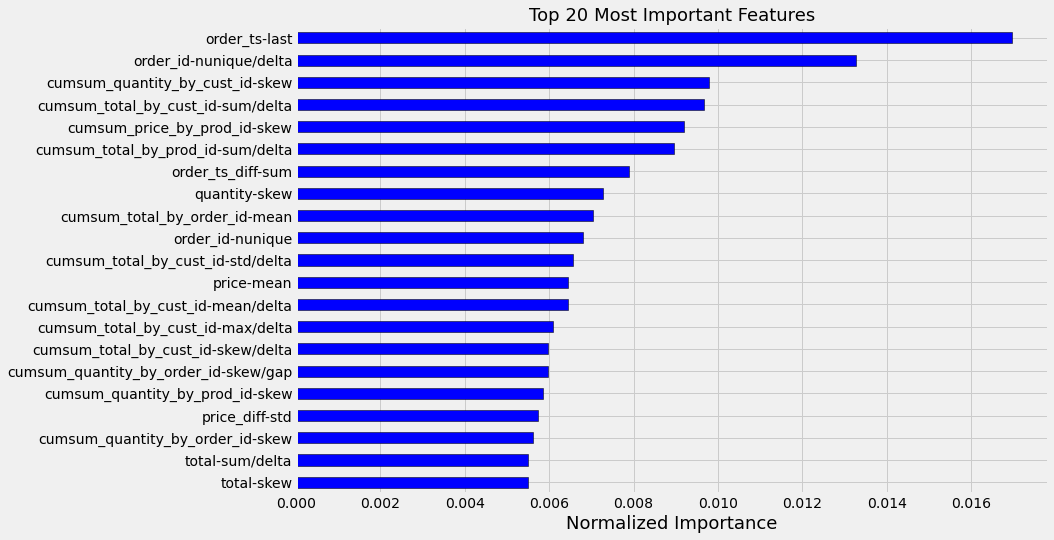

In [18]:
fi = plot_feature_importances(fi)

## 하이퍼 파라미터 튜닝

In [101]:
def objective(trial, label=label_2011_11):
    lgb_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'num_leaves': 2,
        
        # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),
        # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': 3
        'n_estimators': 10000, # 트리 개수
        'early_stopping_rounds': 100,
        'seed': SEED,
        'verbose': -1,
        'n_jobs': -1,    
    }
    
    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, test_preds, fi = make_lgb_oof_prediction(train, y, test, features, model_params=lgb_params)
    
    # Validation 스코어 계산
    val_auc = roc_auc_score(label, y_oof)
    
    return val_auc

In [102]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # 10회 동안 하이퍼 파라미터 탐색

[I 2021-04-22 12:35:28,786] A new study created in memory with name: no-name-bcc1f632-a889-4341-8aa4-d011a0a664ef


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	training's auc: 0.840726	valid_1's auc: 0.807371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	training's auc: 0.845388	valid_1's auc: 0.82464
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856301	valid_1's auc: 0.848886
Early stopping, best iteration is:
[129]	training's auc: 0.847963	valid_1's auc: 0.850976
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844504	valid_1's auc: 0.817134
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858662	valid_1's auc: 0.825051
Early stopping, best iteration is:
[135]	training's auc: 0.850654	valid_1's auc: 0.826739
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856303	valid_1's auc: 0.84284
Early stopping, be

[I 2021-04-22 12:35:35,271] Trial 0 finished with value: 0.8305893815377716 and parameters: {'min_data_in_leaf': 24, 'feature_fraction': 0.9186648577198989, 'bagging_fraction': 0.869734280049505}. Best is trial 0 with value: 0.8305893815377716.


[200]	training's auc: 0.857473	valid_1's auc: 0.835754
Early stopping, best iteration is:
[101]	training's auc: 0.845777	valid_1's auc: 0.838722

Mean AUC = 0.8313013294529187
OOF AUC = 0.8305893815377716
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.861091	valid_1's auc: 0.803817
Early stopping, best iteration is:
[125]	training's auc: 0.852178	valid_1's auc: 0.808111
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	training's auc: 0.845934	valid_1's auc: 0.824362
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856341	valid_1's auc: 0.852806
Early stopping, best iteration is:
[158]	training's auc: 0.851871	valid_1's auc: 0.853086
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's auc: 0.845093	valid_1's auc: 0.816873
Training until validation scores don't improve for 100 rounds
[200]	training's 

[I 2021-04-22 12:35:41,686] Trial 1 finished with value: 0.830466757710913 and parameters: {'min_data_in_leaf': 24, 'feature_fraction': 0.909810322148717, 'bagging_fraction': 0.866317264095861}. Best is trial 0 with value: 0.8305893815377716.


[200]	training's auc: 0.857878	valid_1's auc: 0.838537
Early stopping, best iteration is:
[100]	training's auc: 0.845754	valid_1's auc: 0.84028

Mean AUC = 0.8315871253742596
OOF AUC = 0.830466757710913
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.861047	valid_1's auc: 0.804205
Early stopping, best iteration is:
[127]	training's auc: 0.852364	valid_1's auc: 0.807278
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856908	valid_1's auc: 0.825288
Early stopping, best iteration is:
[266]	training's auc: 0.863449	valid_1's auc: 0.826621
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.85648	valid_1's auc: 0.850472
Early stopping, best iteration is:
[198]	training's auc: 0.856122	valid_1's auc: 0.850696
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's auc: 0.845034	valid_1's auc: 0.815995
Training until validation 

[I 2021-04-22 12:35:48,305] Trial 2 finished with value: 0.8306630857910081 and parameters: {'min_data_in_leaf': 23, 'feature_fraction': 0.9128754379456816, 'bagging_fraction': 0.8654281357131447}. Best is trial 2 with value: 0.8306630857910081.


[200]	training's auc: 0.857462	valid_1's auc: 0.837758
Early stopping, best iteration is:
[105]	training's auc: 0.84642	valid_1's auc: 0.840911

Mean AUC = 0.8314725504114816
OOF AUC = 0.8306630857910081
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.861219	valid_1's auc: 0.801688
Early stopping, best iteration is:
[126]	training's auc: 0.852642	valid_1's auc: 0.807334
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	training's auc: 0.845586	valid_1's auc: 0.824862
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856532	valid_1's auc: 0.850528
Early stopping, best iteration is:
[147]	training's auc: 0.850532	valid_1's auc: 0.850958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's auc: 0.845379	valid_1's auc: 0.817246
Training until validation scores don't improve for 100 rounds
[200]	training's a

[I 2021-04-22 12:35:55,430] Trial 3 finished with value: 0.830189484909379 and parameters: {'min_data_in_leaf': 24, 'feature_fraction': 0.9102174637972854, 'bagging_fraction': 0.8746008378187969}. Best is trial 2 with value: 0.8306630857910081.


[200]	training's auc: 0.857476	valid_1's auc: 0.836682
Early stopping, best iteration is:
[102]	training's auc: 0.84579	valid_1's auc: 0.840874

Mean AUC = 0.8311418125810865
OOF AUC = 0.830189484909379
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.861265	valid_1's auc: 0.805538
Early stopping, best iteration is:
[141]	training's auc: 0.853648	valid_1's auc: 0.807445
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.85705	valid_1's auc: 0.825103
Early stopping, best iteration is:
[209]	training's auc: 0.85796	valid_1's auc: 0.825769
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856765	valid_1's auc: 0.850864
Early stopping, best iteration is:
[198]	training's auc: 0.856122	valid_1's auc: 0.851144
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	training's auc: 0.84653	valid_1's auc: 0.815902
Training until validation sc

[I 2021-04-22 12:36:02,843] Trial 4 finished with value: 0.830205915202607 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9431879395989268, 'bagging_fraction': 0.8652024860493674}. Best is trial 2 with value: 0.8306630857910081.



Mean AUC = 0.8313439962531409
OOF AUC = 0.830205915202607
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	training's auc: 0.840595	valid_1's auc: 0.807278
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857087	valid_1's auc: 0.825936
Early stopping, best iteration is:
[208]	training's auc: 0.857834	valid_1's auc: 0.826102
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.8564	valid_1's auc: 0.850006
Early stopping, best iteration is:
[159]	training's auc: 0.851674	valid_1's auc: 0.851574
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844102	valid_1's auc: 0.817115
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858404	valid_1's auc: 0.825069
Early stopping, best iteration is:
[134]	training's auc: 0.850145	valid_1's auc: 0.828037
Training until valid

[I 2021-04-22 12:36:09,837] Trial 5 finished with value: 0.8312178170471067 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9042379733470831, 'bagging_fraction': 0.872113354569061}. Best is trial 5 with value: 0.8312178170471067.


[200]	training's auc: 0.857565	valid_1's auc: 0.836348
Early stopping, best iteration is:
[101]	training's auc: 0.845566	valid_1's auc: 0.838518

Mean AUC = 0.8318226548015207
OOF AUC = 0.8312178170471067
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.861199	valid_1's auc: 0.803706
Early stopping, best iteration is:
[126]	training's auc: 0.852281	valid_1's auc: 0.808481
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857376	valid_1's auc: 0.824381
Early stopping, best iteration is:
[207]	training's auc: 0.85803	valid_1's auc: 0.825047
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856766	valid_1's auc: 0.849763
Early stopping, best iteration is:
[145]	training's auc: 0.850592	valid_1's auc: 0.851592
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's auc: 0.845782	valid_1's auc: 0.817582
Training until validatio

[I 2021-04-22 12:36:17,038] Trial 6 finished with value: 0.8302700583247562 and parameters: {'min_data_in_leaf': 24, 'feature_fraction': 0.9407772877389954, 'bagging_fraction': 0.8704082848924373}. Best is trial 5 with value: 0.8312178170471067.


[200]	training's auc: 0.857537	valid_1's auc: 0.837665
Early stopping, best iteration is:
[105]	training's auc: 0.846463	valid_1's auc: 0.838036

Mean AUC = 0.8314482042919153
OOF AUC = 0.8302700583247562
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.860522	valid_1's auc: 0.804779
Early stopping, best iteration is:
[128]	training's auc: 0.852276	valid_1's auc: 0.807537
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856998	valid_1's auc: 0.826676
Early stopping, best iteration is:
[202]	training's auc: 0.857281	valid_1's auc: 0.827083
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856813	valid_1's auc: 0.850603
Early stopping, best iteration is:
[159]	training's auc: 0.852007	valid_1's auc: 0.851648
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.843815	valid_1's auc: 0.817489
Training until validati

[I 2021-04-22 12:36:24,696] Trial 7 finished with value: 0.8311697329121237 and parameters: {'min_data_in_leaf': 21, 'feature_fraction': 0.9223045373166738, 'bagging_fraction': 0.8739343668128332}. Best is trial 5 with value: 0.8312178170471067.


[200]	training's auc: 0.857466	valid_1's auc: 0.839854
Early stopping, best iteration is:
[105]	training's auc: 0.846486	valid_1's auc: 0.841783

Mean AUC = 0.8321194669062689
OOF AUC = 0.8311697329121237
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.860968	valid_1's auc: 0.803224
Early stopping, best iteration is:
[125]	training's auc: 0.852179	valid_1's auc: 0.808129
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857226	valid_1's auc: 0.825177
Early stopping, best iteration is:
[270]	training's auc: 0.863752	valid_1's auc: 0.82688
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856342	valid_1's auc: 0.852806
Early stopping, best iteration is:
[158]	training's auc: 0.851872	valid_1's auc: 0.853086
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844372	valid_1's auc: 0.816929
Training until validatio

[I 2021-04-22 12:36:31,943] Trial 8 finished with value: 0.8306121240340473 and parameters: {'min_data_in_leaf': 24, 'feature_fraction': 0.9095695134826566, 'bagging_fraction': 0.8663850729060353}. Best is trial 5 with value: 0.8312178170471067.


[200]	training's auc: 0.857588	valid_1's auc: 0.838555
Early stopping, best iteration is:
[105]	training's auc: 0.84665	valid_1's auc: 0.841078

Mean AUC = 0.8318092059902936
OOF AUC = 0.8306121240340473
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.860484	valid_1's auc: 0.801633
Early stopping, best iteration is:
[162]	training's auc: 0.857153	valid_1's auc: 0.806427
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857196	valid_1's auc: 0.82477
Early stopping, best iteration is:
[213]	training's auc: 0.858397	valid_1's auc: 0.826121
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.85637	valid_1's auc: 0.851536
Early stopping, best iteration is:
[159]	training's auc: 0.851966	valid_1's auc: 0.852656
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844461	valid_1's auc: 0.816425
Training until validation 

[I 2021-04-22 12:36:38,769] Trial 9 finished with value: 0.8298997733547798 and parameters: {'min_data_in_leaf': 21, 'feature_fraction': 0.944555848645672, 'bagging_fraction': 0.867252579461254}. Best is trial 5 with value: 0.8312178170471067.


[200]	training's auc: 0.858012	valid_1's auc: 0.838463
Early stopping, best iteration is:
[101]	training's auc: 0.845566	valid_1's auc: 0.840744

Mean AUC = 0.831529057379186
OOF AUC = 0.8298997733547798
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.861018	valid_1's auc: 0.804298
Early stopping, best iteration is:
[123]	training's auc: 0.852236	valid_1's auc: 0.808481
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857186	valid_1's auc: 0.825917
Early stopping, best iteration is:
[211]	training's auc: 0.858252	valid_1's auc: 0.826472
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856744	valid_1's auc: 0.849576
Early stopping, best iteration is:
[159]	training's auc: 0.851979	valid_1's auc: 0.851032
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844196	valid_1's auc: 0.817395
Training until validatio

[I 2021-04-22 12:36:45,797] Trial 10 finished with value: 0.8309711769956587 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9317439077202623, 'bagging_fraction': 0.8724836632503739}. Best is trial 5 with value: 0.8312178170471067.


Early stopping, best iteration is:
[83]	training's auc: 0.84243	valid_1's auc: 0.84105

Mean AUC = 0.8318842891525281
OOF AUC = 0.8309711769956587
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's auc: 0.840989	valid_1's auc: 0.809231
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857539	valid_1's auc: 0.82688
Early stopping, best iteration is:
[189]	training's auc: 0.856666	valid_1's auc: 0.827028
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856563	valid_1's auc: 0.848568
Early stopping, best iteration is:
[159]	training's auc: 0.851862	valid_1's auc: 0.850062
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.859474	valid_1's auc: 0.812589
Early stopping, best iteration is:
[106]	training's auc: 0.849119	valid_1's auc: 0.816994
Training until validation scores don't improve for 100 rounds
[200]	training's auc

[I 2021-04-22 12:36:52,404] Trial 11 finished with value: 0.8311101382892295 and parameters: {'min_data_in_leaf': 21, 'feature_fraction': 0.9282915476638798, 'bagging_fraction': 0.8747994727719834}. Best is trial 5 with value: 0.8312178170471067.


[200]	training's auc: 0.85741	valid_1's auc: 0.838815
Early stopping, best iteration is:
[101]	training's auc: 0.845504	valid_1's auc: 0.840902

Mean AUC = 0.8314889510676019
OOF AUC = 0.8311101382892295
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.861088	valid_1's auc: 0.805594
Early stopping, best iteration is:
[123]	training's auc: 0.852122	valid_1's auc: 0.809888
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857424	valid_1's auc: 0.826306
Early stopping, best iteration is:
[185]	training's auc: 0.856051	valid_1's auc: 0.827139
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856284	valid_1's auc: 0.850174
Early stopping, best iteration is:
[159]	training's auc: 0.851671	valid_1's auc: 0.850808
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844197	valid_1's auc: 0.817395
Training until validatio

[I 2021-04-22 12:36:59,117] Trial 12 finished with value: 0.8309294978902388 and parameters: {'min_data_in_leaf': 21, 'feature_fraction': 0.9007861642383242, 'bagging_fraction': 0.8724574312209876}. Best is trial 5 with value: 0.8312178170471067.


[200]	training's auc: 0.857486	valid_1's auc: 0.838333
Early stopping, best iteration is:
[101]	training's auc: 0.845618	valid_1's auc: 0.840114

Mean AUC = 0.8317250858297038
OOF AUC = 0.8309294978902388
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	training's auc: 0.841136	valid_1's auc: 0.807704
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	training's auc: 0.84591	valid_1's auc: 0.825436
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856847	valid_1's auc: 0.849632
Early stopping, best iteration is:
[159]	training's auc: 0.852015	valid_1's auc: 0.851107
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's auc: 0.845975	valid_1's auc: 0.816182
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858084	valid_1's auc: 0.823325
Early stopping, bes

[I 2021-04-22 12:37:05,538] Trial 13 finished with value: 0.8307865450565053 and parameters: {'min_data_in_leaf': 22, 'feature_fraction': 0.902787662757778, 'bagging_fraction': 0.8728369383506386}. Best is trial 5 with value: 0.8312178170471067.


[200]	training's auc: 0.857617	valid_1's auc: 0.839372
Early stopping, best iteration is:
[104]	training's auc: 0.846675	valid_1's auc: 0.841245

Mean AUC = 0.8315398708205235
OOF AUC = 0.8307865450565053
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.860979	valid_1's auc: 0.804483
Early stopping, best iteration is:
[125]	training's auc: 0.852243	valid_1's auc: 0.808222
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857334	valid_1's auc: 0.827028
Early stopping, best iteration is:
[179]	training's auc: 0.855236	valid_1's auc: 0.828083
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.85644	valid_1's auc: 0.849427
Early stopping, best iteration is:
[159]	training's auc: 0.851687	valid_1's auc: 0.851088
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844492	valid_1's auc: 0.817265
Training until validatio

[I 2021-04-22 12:37:12,223] Trial 14 finished with value: 0.8306072042287305 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9213243910807725, 'bagging_fraction': 0.8708973816187298}. Best is trial 5 with value: 0.8312178170471067.


[200]	training's auc: 0.857408	valid_1's auc: 0.835049
Early stopping, best iteration is:
[101]	training's auc: 0.845664	valid_1's auc: 0.839056

Mean AUC = 0.8317438884512869
OOF AUC = 0.8306072042287305
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.861163	valid_1's auc: 0.803261
Early stopping, best iteration is:
[137]	training's auc: 0.853557	valid_1's auc: 0.807519
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857047	valid_1's auc: 0.825862
Early stopping, best iteration is:
[206]	training's auc: 0.857702	valid_1's auc: 0.826509
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856699	valid_1's auc: 0.850528
Early stopping, best iteration is:
[158]	training's auc: 0.851822	valid_1's auc: 0.851387
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.843814	valid_1's auc: 0.81747
Training until validatio

[I 2021-04-22 12:37:19,172] Trial 15 finished with value: 0.8308874474787575 and parameters: {'min_data_in_leaf': 22, 'feature_fraction': 0.9344503646423171, 'bagging_fraction': 0.874040376796981}. Best is trial 5 with value: 0.8312178170471067.


[200]	training's auc: 0.857469	valid_1's auc: 0.840021
Early stopping, best iteration is:
[105]	training's auc: 0.846485	valid_1's auc: 0.841783

Mean AUC = 0.8319849327744903
OOF AUC = 0.8308874474787575
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.860729	valid_1's auc: 0.803187
Early stopping, best iteration is:
[125]	training's auc: 0.852087	valid_1's auc: 0.808037
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.8573	valid_1's auc: 0.826639
Early stopping, best iteration is:
[231]	training's auc: 0.860665	valid_1's auc: 0.827435
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856547	valid_1's auc: 0.850995
Early stopping, best iteration is:
[158]	training's auc: 0.851952	valid_1's auc: 0.851704
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's auc: 0.845447	valid_1's auc: 0.816761
Training until validation

[I 2021-04-22 12:37:26,146] Trial 16 finished with value: 0.8308442831490912 and parameters: {'min_data_in_leaf': 21, 'feature_fraction': 0.9195794225186901, 'bagging_fraction': 0.8689523149352403}. Best is trial 5 with value: 0.8312178170471067.


[200]	training's auc: 0.857634	valid_1's auc: 0.837591
Early stopping, best iteration is:
[100]	training's auc: 0.845494	valid_1's auc: 0.840151

Mean AUC = 0.8319686025673432
OOF AUC = 0.8308442831490912
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's auc: 0.839545	valid_1's auc: 0.808166
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857085	valid_1's auc: 0.824733
Early stopping, best iteration is:
[203]	training's auc: 0.857426	valid_1's auc: 0.825177
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856694	valid_1's auc: 0.85023
Early stopping, best iteration is:
[159]	training's auc: 0.851981	valid_1's auc: 0.852003
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844024	valid_1's auc: 0.815323
Training until validation scores don't improve for 100 rounds
[200]	training's a

[I 2021-04-22 12:37:32,932] Trial 17 finished with value: 0.8309635652213951 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9034171261860715, 'bagging_fraction': 0.8735761613456272}. Best is trial 5 with value: 0.8312178170471067.


[200]	training's auc: 0.857361	valid_1's auc: 0.839038
Early stopping, best iteration is:
[105]	training's auc: 0.846353	valid_1's auc: 0.841041

Mean AUC = 0.8314201985654515
OOF AUC = 0.8309635652213951
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.861159	valid_1's auc: 0.803558
Early stopping, best iteration is:
[123]	training's auc: 0.852084	valid_1's auc: 0.807371
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857464	valid_1's auc: 0.827268
Early stopping, best iteration is:
[192]	training's auc: 0.856974	valid_1's auc: 0.827472
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856212	valid_1's auc: 0.850435
Early stopping, best iteration is:
[159]	training's auc: 0.851697	valid_1's auc: 0.851032
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844555	valid_1's auc: 0.817078
Training until validati

[I 2021-04-22 12:37:39,501] Trial 18 finished with value: 0.8307815324246731 and parameters: {'min_data_in_leaf': 21, 'feature_fraction': 0.9244599233996114, 'bagging_fraction': 0.8714869167457071}. Best is trial 5 with value: 0.8312178170471067.


[200]	training's auc: 0.857786	valid_1's auc: 0.837776
Early stopping, best iteration is:
[101]	training's auc: 0.845804	valid_1's auc: 0.839483

Mean AUC = 0.8316624383916368
OOF AUC = 0.8307815324246731
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.861308	valid_1's auc: 0.803372
Early stopping, best iteration is:
[127]	training's auc: 0.852925	valid_1's auc: 0.80626
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857241	valid_1's auc: 0.82538
Early stopping, best iteration is:
[271]	training's auc: 0.863957	valid_1's auc: 0.826769
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856578	valid_1's auc: 0.850155
Early stopping, best iteration is:
[158]	training's auc: 0.852095	valid_1's auc: 0.852638
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844288	valid_1's auc: 0.816798
Training until validation

[I 2021-04-22 12:37:46,584] Trial 19 finished with value: 0.8301026921174693 and parameters: {'min_data_in_leaf': 22, 'feature_fraction': 0.9499425938799934, 'bagging_fraction': 0.8719479030515356}. Best is trial 5 with value: 0.8312178170471067.


[200]	training's auc: 0.857256	valid_1's auc: 0.836645
Early stopping, best iteration is:
[105]	training's auc: 0.846426	valid_1's auc: 0.838871

Mean AUC = 0.8313381017395538
OOF AUC = 0.8301026921174693
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's auc: 0.84095	valid_1's auc: 0.808361
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856748	valid_1's auc: 0.824122
Early stopping, best iteration is:
[212]	training's auc: 0.857922	valid_1's auc: 0.824399
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856506	valid_1's auc: 0.85064
Early stopping, best iteration is:
[114]	training's auc: 0.846756	valid_1's auc: 0.851966
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's auc: 0.845894	valid_1's auc: 0.816938
Training until validation scores don't improve for 100 rounds
[200]	training's au

[I 2021-04-22 12:37:53,417] Trial 20 finished with value: 0.8312697070692218 and parameters: {'min_data_in_leaf': 23, 'feature_fraction': 0.9377984613773191, 'bagging_fraction': 0.8734863025327781}. Best is trial 20 with value: 0.8312697070692218.


Early stopping, best iteration is:
[81]	training's auc: 0.842161	valid_1's auc: 0.840958

Mean AUC = 0.8319666911995999
OOF AUC = 0.8312697070692218
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	training's auc: 0.840176	valid_1's auc: 0.807926
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856659	valid_1's auc: 0.823863
Early stopping, best iteration is:
[269]	training's auc: 0.863095	valid_1's auc: 0.824825
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.85674	valid_1's auc: 0.850024
Early stopping, best iteration is:
[159]	training's auc: 0.852079	valid_1's auc: 0.851032
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's auc: 0.845676	valid_1's auc: 0.816546
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858564	valid_1's auc: 0.822639
Early stopping, bes

[I 2021-04-22 12:38:00,274] Trial 21 finished with value: 0.8306551027106828 and parameters: {'min_data_in_leaf': 23, 'feature_fraction': 0.9369135450970061, 'bagging_fraction': 0.8734439459854373}. Best is trial 20 with value: 0.8312697070692218.


[200]	training's auc: 0.857567	valid_1's auc: 0.838574
Early stopping, best iteration is:
[105]	training's auc: 0.846281	valid_1's auc: 0.84092

Mean AUC = 0.8316032080144675
OOF AUC = 0.8306551027106828
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's auc: 0.84099	valid_1's auc: 0.809268
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857232	valid_1's auc: 0.824621
Early stopping, best iteration is:
[274]	training's auc: 0.864246	valid_1's auc: 0.825325
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856353	valid_1's auc: 0.850304
Early stopping, best iteration is:
[169]	training's auc: 0.853378	valid_1's auc: 0.851406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.843503	valid_1's auc: 0.817498
Training until validation scores don't improve for 100 rounds
[200]	training's au

[I 2021-04-22 12:38:07,155] Trial 22 finished with value: 0.8307207310570786 and parameters: {'min_data_in_leaf': 23, 'feature_fraction': 0.9153262685370374, 'bagging_fraction': 0.8748938831492867}. Best is trial 20 with value: 0.8312697070692218.


[200]	training's auc: 0.857432	valid_1's auc: 0.838592
Early stopping, best iteration is:
[103]	training's auc: 0.845956	valid_1's auc: 0.840392

Mean AUC = 0.8314728442749444
OOF AUC = 0.8307207310570786
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's auc: 0.840814	valid_1's auc: 0.808389
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	training's auc: 0.844942	valid_1's auc: 0.824224
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856954	valid_1's auc: 0.849278
Early stopping, best iteration is:
[159]	training's auc: 0.852159	valid_1's auc: 0.850118
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.84433	valid_1's auc: 0.816882
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858247	valid_1's auc: 0.822565
Early stopping, bes

[I 2021-04-22 12:38:13,671] Trial 23 finished with value: 0.8303991800076934 and parameters: {'min_data_in_leaf': 23, 'feature_fraction': 0.948941817912746, 'bagging_fraction': 0.8732053028583101}. Best is trial 20 with value: 0.8312697070692218.


Early stopping, best iteration is:
[86]	training's auc: 0.842988	valid_1's auc: 0.840253

Mean AUC = 0.8310101916502813
OOF AUC = 0.8303991800076934
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.860829	valid_1's auc: 0.802762
Early stopping, best iteration is:
[141]	training's auc: 0.85384	valid_1's auc: 0.808
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857178	valid_1's auc: 0.826676
Early stopping, best iteration is:
[188]	training's auc: 0.856327	valid_1's auc: 0.827083
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856401	valid_1's auc: 0.851592
Early stopping, best iteration is:
[159]	training's auc: 0.851878	valid_1's auc: 0.851704
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.84381	valid_1's auc: 0.817451
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 

[I 2021-04-22 12:38:20,516] Trial 24 finished with value: 0.8307324271980205 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9257221005700621, 'bagging_fraction': 0.8742749845438763}. Best is trial 20 with value: 0.8312697070692218.


Early stopping, best iteration is:
[84]	training's auc: 0.842662	valid_1's auc: 0.840902

Mean AUC = 0.8318030909016448
OOF AUC = 0.8307324271980205
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.861408	valid_1's auc: 0.80626
Early stopping, best iteration is:
[163]	training's auc: 0.857519	valid_1's auc: 0.807741
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	training's auc: 0.845415	valid_1's auc: 0.825362
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856645	valid_1's auc: 0.850099
Early stopping, best iteration is:
[159]	training's auc: 0.852075	valid_1's auc: 0.852022
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's auc: 0.844658	valid_1's auc: 0.817451
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858283	valid_1's auc: 0.825162
Early stopping, bes

[I 2021-04-22 12:38:27,251] Trial 25 finished with value: 0.8301047343008084 and parameters: {'min_data_in_leaf': 22, 'feature_fraction': 0.9376701243675698, 'bagging_fraction': 0.8716437604376722}. Best is trial 20 with value: 0.8312697070692218.


Early stopping, best iteration is:
[83]	training's auc: 0.842716	valid_1's auc: 0.839362

Mean AUC = 0.8314957875613592
OOF AUC = 0.8301047343008084
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.860654	valid_1's auc: 0.803558
Early stopping, best iteration is:
[104]	training's auc: 0.849632	valid_1's auc: 0.809018
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857243	valid_1's auc: 0.824307
Early stopping, best iteration is:
[270]	training's auc: 0.863396	valid_1's auc: 0.825528
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856802	valid_1's auc: 0.850136
Early stopping, best iteration is:
[159]	training's auc: 0.851825	valid_1's auc: 0.851275
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's auc: 0.845716	valid_1's auc: 0.816163
Training until validation scores don't improve for 100 rounds
[200]	training's 

[I 2021-04-22 12:38:34,209] Trial 26 finished with value: 0.8308265532846477 and parameters: {'min_data_in_leaf': 21, 'feature_fraction': 0.9299236142630094, 'bagging_fraction': 0.8738753084062445}. Best is trial 20 with value: 0.8312697070692218.


Early stopping, best iteration is:
[83]	training's auc: 0.842476	valid_1's auc: 0.841468

Mean AUC = 0.8318244027463438
OOF AUC = 0.8308265532846477
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	training's auc: 0.840715	valid_1's auc: 0.807371
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857093	valid_1's auc: 0.825103
Early stopping, best iteration is:
[211]	training's auc: 0.858242	valid_1's auc: 0.825547
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856041	valid_1's auc: 0.84812
Early stopping, best iteration is:
[144]	training's auc: 0.850129	valid_1's auc: 0.851032
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844495	valid_1's auc: 0.817134
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858176	valid_1's auc: 0.826256
Early stopping, bes

[I 2021-04-22 12:38:40,705] Trial 27 finished with value: 0.8310221387526197 and parameters: {'min_data_in_leaf': 23, 'feature_fraction': 0.9060815369813083, 'bagging_fraction': 0.8696296038786979}. Best is trial 20 with value: 0.8312697070692218.


[200]	training's auc: 0.857709	valid_1's auc: 0.836774
Early stopping, best iteration is:
[101]	training's auc: 0.845779	valid_1's auc: 0.840132

Mean AUC = 0.8316981440229829
OOF AUC = 0.8310221387526197
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.860979	valid_1's auc: 0.804483
Early stopping, best iteration is:
[125]	training's auc: 0.852243	valid_1's auc: 0.808222
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857334	valid_1's auc: 0.827028
Early stopping, best iteration is:
[179]	training's auc: 0.855236	valid_1's auc: 0.828083
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856521	valid_1's auc: 0.850939
Early stopping, best iteration is:
[159]	training's auc: 0.851772	valid_1's auc: 0.85191
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844492	valid_1's auc: 0.817265
Training until validatio

[I 2021-04-22 12:38:47,340] Trial 28 finished with value: 0.8303152648377615 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9329040460864328, 'bagging_fraction': 0.8708949340385261}. Best is trial 20 with value: 0.8312697070692218.


[200]	training's auc: 0.857407	valid_1's auc: 0.835068
Early stopping, best iteration is:
[101]	training's auc: 0.845664	valid_1's auc: 0.839056

Mean AUC = 0.8314615042409466
OOF AUC = 0.8303152648377615
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	training's auc: 0.840599	valid_1's auc: 0.807296
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857194	valid_1's auc: 0.826028
Early stopping, best iteration is:
[177]	training's auc: 0.854934	valid_1's auc: 0.826232
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.85645	valid_1's auc: 0.850304
Early stopping, best iteration is:
[158]	training's auc: 0.851665	valid_1's auc: 0.852675
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's auc: 0.844635	valid_1's auc: 0.817321
Training until validation scores don't improve for 100 rounds
[200]	training's a

[I 2021-04-22 12:38:53,849] Trial 29 finished with value: 0.8310586195731763 and parameters: {'min_data_in_leaf': 21, 'feature_fraction': 0.9170136545153434, 'bagging_fraction': 0.872141051260559}. Best is trial 20 with value: 0.8312697070692218.


Early stopping, best iteration is:
[83]	training's auc: 0.842558	valid_1's auc: 0.837971

Mean AUC = 0.8316425670717618
OOF AUC = 0.8310586195731763
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.860835	valid_1's auc: 0.803243
Early stopping, best iteration is:
[164]	training's auc: 0.857278	valid_1's auc: 0.808
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.85736	valid_1's auc: 0.825621
Early stopping, best iteration is:
[160]	training's auc: 0.853364	valid_1's auc: 0.826658
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856383	valid_1's auc: 0.850958
Early stopping, best iteration is:
[119]	training's auc: 0.847407	valid_1's auc: 0.851928
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's auc: 0.84595	valid_1's auc: 0.817022
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 

[I 2021-04-22 12:39:00,445] Trial 30 finished with value: 0.8303183281127701 and parameters: {'min_data_in_leaf': 22, 'feature_fraction': 0.9228035045681128, 'bagging_fraction': 0.8693226551562608}. Best is trial 20 with value: 0.8312697070692218.


[200]	training's auc: 0.857427	valid_1's auc: 0.836329
Early stopping, best iteration is:
[101]	training's auc: 0.845696	valid_1's auc: 0.839891

Mean AUC = 0.8316017847166598
OOF AUC = 0.8303183281127701
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.860953	valid_1's auc: 0.804205
Early stopping, best iteration is:
[123]	training's auc: 0.852366	valid_1's auc: 0.809814
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857246	valid_1's auc: 0.826158
Early stopping, best iteration is:
[179]	training's auc: 0.855089	valid_1's auc: 0.826824
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856633	valid_1's auc: 0.849446
Early stopping, best iteration is:
[153]	training's auc: 0.851116	valid_1's auc: 0.849875
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.859423	valid_1's auc: 0.812813
Early stopping, best iteration is:
[105]	training's auc: 

[I 2021-04-22 12:39:07,201] Trial 31 finished with value: 0.8308685108696137 and parameters: {'min_data_in_leaf': 21, 'feature_fraction': 0.9281901255240201, 'bagging_fraction': 0.8749459320753479}. Best is trial 20 with value: 0.8312697070692218.


Early stopping, best iteration is:
[81]	training's auc: 0.842426	valid_1's auc: 0.840605

Mean AUC = 0.8315510925681149
OOF AUC = 0.8308685108696137
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	training's auc: 0.840635	valid_1's auc: 0.807639
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857134	valid_1's auc: 0.825788
Early stopping, best iteration is:
[179]	training's auc: 0.855305	valid_1's auc: 0.82625
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856824	valid_1's auc: 0.848998
Early stopping, best iteration is:
[158]	training's auc: 0.851829	valid_1's auc: 0.850286
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844254	valid_1's auc: 0.81579
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.85888	valid_1's auc: 0.826293
Early stopping, best 

[I 2021-04-22 12:39:14,130] Trial 32 finished with value: 0.8309417509902735 and parameters: {'min_data_in_leaf': 21, 'feature_fraction': 0.9267167654071796, 'bagging_fraction': 0.8729948689865871}. Best is trial 20 with value: 0.8312697070692218.


Early stopping, best iteration is:
[83]	training's auc: 0.84276	valid_1's auc: 0.840976

Mean AUC = 0.8316335587100748
OOF AUC = 0.8309417509902735
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.860878	valid_1's auc: 0.805279
Early stopping, best iteration is:
[123]	training's auc: 0.852064	valid_1's auc: 0.809184
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's auc: 0.845862	valid_1's auc: 0.824214
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856627	valid_1's auc: 0.849726
Early stopping, best iteration is:
[153]	training's auc: 0.85143	valid_1's auc: 0.849931
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844013	valid_1's auc: 0.816593
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858277	valid_1's auc: 0.822787
Early stopping, best

[I 2021-04-22 12:39:20,886] Trial 33 finished with value: 0.8304972976344834 and parameters: {'min_data_in_leaf': 22, 'feature_fraction': 0.940290763712849, 'bagging_fraction': 0.8749590076277907}. Best is trial 20 with value: 0.8312697070692218.


Early stopping, best iteration is:
[81]	training's auc: 0.842358	valid_1's auc: 0.84118

Mean AUC = 0.831348268206881
OOF AUC = 0.8304972976344834
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	training's auc: 0.840704	valid_1's auc: 0.807768
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857243	valid_1's auc: 0.825899
Early stopping, best iteration is:
[270]	training's auc: 0.863701	valid_1's auc: 0.826954
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856217	valid_1's auc: 0.851163
Early stopping, best iteration is:
[159]	training's auc: 0.851704	valid_1's auc: 0.852432
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.843791	valid_1's auc: 0.817638
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858543	valid_1's auc: 0.823659
Early stopping, best

[I 2021-04-22 12:39:27,598] Trial 34 finished with value: 0.8312437156449066 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9471747980981655, 'bagging_fraction': 0.8743863769180801}. Best is trial 20 with value: 0.8312697070692218.


Early stopping, best iteration is:
[84]	training's auc: 0.842639	valid_1's auc: 0.841755

Mean AUC = 0.832102401495087
OOF AUC = 0.8312437156449066
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	training's auc: 0.840755	valid_1's auc: 0.80763
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.85718	valid_1's auc: 0.826676
Early stopping, best iteration is:
[188]	training's auc: 0.856328	valid_1's auc: 0.827065
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856215	valid_1's auc: 0.851163
Early stopping, best iteration is:
[159]	training's auc: 0.851711	valid_1's auc: 0.852432
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.843795	valid_1's auc: 0.817638
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.85848	valid_1's auc: 0.822973
Early stopping, best i

[I 2021-04-22 12:39:34,169] Trial 35 finished with value: 0.831570743458701 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9479669048543315, 'bagging_fraction': 0.874311129402975}. Best is trial 35 with value: 0.831570743458701.


Early stopping, best iteration is:
[84]	training's auc: 0.842644	valid_1's auc: 0.841737

Mean AUC = 0.8322146379466883
OOF AUC = 0.831570743458701
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	training's auc: 0.840755	valid_1's auc: 0.80763
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.85718	valid_1's auc: 0.826676
Early stopping, best iteration is:
[188]	training's auc: 0.856328	valid_1's auc: 0.827065
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856215	valid_1's auc: 0.851163
Early stopping, best iteration is:
[159]	training's auc: 0.851711	valid_1's auc: 0.852432
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.843795	valid_1's auc: 0.817638
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.85848	valid_1's auc: 0.822973
Early stopping, best i

[I 2021-04-22 12:39:40,948] Trial 36 finished with value: 0.831570743458701 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.947064338106608, 'bagging_fraction': 0.8743086344998942}. Best is trial 35 with value: 0.831570743458701.


Early stopping, best iteration is:
[84]	training's auc: 0.842644	valid_1's auc: 0.841737

Mean AUC = 0.8322146379466883
OOF AUC = 0.831570743458701
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.86156	valid_1's auc: 0.802651
Early stopping, best iteration is:
[117]	training's auc: 0.85101	valid_1's auc: 0.807926
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857044	valid_1's auc: 0.825936
Early stopping, best iteration is:
[188]	training's auc: 0.856334	valid_1's auc: 0.826269
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856618	valid_1's auc: 0.849147
Early stopping, best iteration is:
[171]	training's auc: 0.853521	valid_1's auc: 0.85008
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's auc: 0.845208	valid_1's auc: 0.817171
Training until validation scores don't improve for 100 rounds
[200]	training's auc:

[I 2021-04-22 12:39:47,710] Trial 37 finished with value: 0.8304827238715637 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9467246203392549, 'bagging_fraction': 0.8744703637707907}. Best is trial 35 with value: 0.831570743458701.


Early stopping, best iteration is:
[80]	training's auc: 0.841994	valid_1's auc: 0.840939

Mean AUC = 0.8313513274825637
OOF AUC = 0.8304827238715637
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's auc: 0.841071	valid_1's auc: 0.807583
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857086	valid_1's auc: 0.825547
Early stopping, best iteration is:
[188]	training's auc: 0.856341	valid_1's auc: 0.826269
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856531	valid_1's auc: 0.85163
Early stopping, best iteration is:
[168]	training's auc: 0.852897	valid_1's auc: 0.852376
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's auc: 0.845148	valid_1's auc: 0.816481
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858542	valid_1's auc: 0.823678
Early stopping, bes

[I 2021-04-22 12:39:54,224] Trial 38 finished with value: 0.831134366009752 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9468611916217315, 'bagging_fraction': 0.8744191344121504}. Best is trial 35 with value: 0.831570743458701.


Early stopping, best iteration is:
[84]	training's auc: 0.842657	valid_1's auc: 0.841644

Mean AUC = 0.8317716412262872
OOF AUC = 0.831134366009752
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's auc: 0.840905	valid_1's auc: 0.808888
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856876	valid_1's auc: 0.824825
Early stopping, best iteration is:
[185]	training's auc: 0.855883	valid_1's auc: 0.825066
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.85697	valid_1's auc: 0.851238
Early stopping, best iteration is:
[159]	training's auc: 0.852347	valid_1's auc: 0.85148
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844547	valid_1's auc: 0.815127
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858263	valid_1's auc: 0.824772
Early stopping, best 

[I 2021-04-22 12:40:00,924] Trial 39 finished with value: 0.8308397346498362 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9428122806633784, 'bagging_fraction': 0.8735866517389181}. Best is trial 35 with value: 0.831570743458701.


Early stopping, best iteration is:
[81]	training's auc: 0.842161	valid_1's auc: 0.84092

Mean AUC = 0.8315902814155638
OOF AUC = 0.8308397346498362
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's auc: 0.841	valid_1's auc: 0.808352
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	training's auc: 0.845536	valid_1's auc: 0.825325
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856968	valid_1's auc: 0.848494
Early stopping, best iteration is:
[159]	training's auc: 0.852133	valid_1's auc: 0.850211
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.84426	valid_1's auc: 0.815771
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858445	valid_1's auc: 0.821415
Early stopping, best iteration is:
[126]	training's auc: 0.849872	valid_1's auc

[I 2021-04-22 12:40:07,332] Trial 40 finished with value: 0.8306447989674721 and parameters: {'min_data_in_leaf': 23, 'feature_fraction': 0.9474192970078391, 'bagging_fraction': 0.8730164876848999}. Best is trial 35 with value: 0.831570743458701.


Early stopping, best iteration is:
[83]	training's auc: 0.842764	valid_1's auc: 0.840995

Mean AUC = 0.8314508256031746
OOF AUC = 0.8306447989674721
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.861278	valid_1's auc: 0.804224
Early stopping, best iteration is:
[125]	training's auc: 0.852364	valid_1's auc: 0.807463
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.85693	valid_1's auc: 0.827065
Early stopping, best iteration is:
[209]	training's auc: 0.857933	valid_1's auc: 0.827565
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856339	valid_1's auc: 0.850752
Early stopping, best iteration is:
[159]	training's auc: 0.851937	valid_1's auc: 0.851312
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.843815	valid_1's auc: 0.817489
Training until validation scores don't improve for 100 rounds
[200]	training's a

[I 2021-04-22 12:40:13,941] Trial 41 finished with value: 0.8308322157020878 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9405449802570729, 'bagging_fraction': 0.8739572343760769}. Best is trial 35 with value: 0.831570743458701.


Early stopping, best iteration is:
[83]	training's auc: 0.842426	valid_1's auc: 0.841737

Mean AUC = 0.8317648543013213
OOF AUC = 0.8308322157020878
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	training's auc: 0.841207	valid_1's auc: 0.808426
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857048	valid_1's auc: 0.825214
Early stopping, best iteration is:
[211]	training's auc: 0.858071	valid_1's auc: 0.82588
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856847	valid_1's auc: 0.848848
Early stopping, best iteration is:
[159]	training's auc: 0.852216	valid_1's auc: 0.850062
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's auc: 0.84562	valid_1's auc: 0.815715
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858555	valid_1's auc: 0.824587
Early stopping, best

[I 2021-04-22 12:40:20,848] Trial 42 finished with value: 0.830862941278689 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9433160719843827, 'bagging_fraction': 0.8725717447111114}. Best is trial 35 with value: 0.831570743458701.


Early stopping, best iteration is:
[83]	training's auc: 0.842845	valid_1's auc: 0.841254

Mean AUC = 0.8314858049642951
OOF AUC = 0.830862941278689
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	training's auc: 0.841297	valid_1's auc: 0.809666
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856752	valid_1's auc: 0.824936
Early stopping, best iteration is:
[188]	training's auc: 0.856009	valid_1's auc: 0.825473
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856461	valid_1's auc: 0.849259
Early stopping, best iteration is:
[153]	training's auc: 0.851355	valid_1's auc: 0.849968
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's auc: 0.845208	valid_1's auc: 0.817171
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858489	valid_1's auc: 0.823251
Early stopping, bes

[I 2021-04-22 12:40:27,644] Trial 43 finished with value: 0.8305395336989956 and parameters: {'min_data_in_leaf': 24, 'feature_fraction': 0.949694849483172, 'bagging_fraction': 0.8744714668872015}. Best is trial 35 with value: 0.831570743458701.


Early stopping, best iteration is:
[80]	training's auc: 0.841994	valid_1's auc: 0.840939

Mean AUC = 0.8312341815564287
OOF AUC = 0.8305395336989956
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.860889	valid_1's auc: 0.804853
Early stopping, best iteration is:
[125]	training's auc: 0.851864	valid_1's auc: 0.808
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856888	valid_1's auc: 0.82477
Early stopping, best iteration is:
[207]	training's auc: 0.857776	valid_1's auc: 0.825232
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856831	valid_1's auc: 0.85036
Early stopping, best iteration is:
[159]	training's auc: 0.852374	valid_1's auc: 0.851144
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.843974	valid_1's auc: 0.815809
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 

[I 2021-04-22 12:40:34,563] Trial 44 finished with value: 0.8306331028265304 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9452025128036516, 'bagging_fraction': 0.8736861667288951}. Best is trial 35 with value: 0.831570743458701.


[200]	training's auc: 0.857702	valid_1's auc: 0.839093
Early stopping, best iteration is:
[101]	training's auc: 0.845575	valid_1's auc: 0.840614

Mean AUC = 0.8315424241586516
OOF AUC = 0.8306331028265304
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's auc: 0.840944	valid_1's auc: 0.808416
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857184	valid_1's auc: 0.825269
Early stopping, best iteration is:
[210]	training's auc: 0.858186	valid_1's auc: 0.825658
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856559	valid_1's auc: 0.849688
Early stopping, best iteration is:
[158]	training's auc: 0.851839	valid_1's auc: 0.851406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844332	valid_1's auc: 0.816882
Training until validation scores don't improve for 100 rounds
[200]	training's 

[I 2021-04-22 12:40:41,364] Trial 45 finished with value: 0.8311010412907193 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.937675607916718, 'bagging_fraction': 0.8732433955252737}. Best is trial 35 with value: 0.831570743458701.


Early stopping, best iteration is:
[86]	training's auc: 0.842987	valid_1's auc: 0.840271

Mean AUC = 0.8316348924620256
OOF AUC = 0.8311010412907193
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.861023	valid_1's auc: 0.803928
Early stopping, best iteration is:
[119]	training's auc: 0.851431	valid_1's auc: 0.807741
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857029	valid_1's auc: 0.825454
Early stopping, best iteration is:
[160]	training's auc: 0.85334	valid_1's auc: 0.826102
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856269	valid_1's auc: 0.850286
Early stopping, best iteration is:
[159]	training's auc: 0.851716	valid_1's auc: 0.851667
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.84381	valid_1's auc: 0.81747
Training until validation scores don't improve for 100 rounds
[200]	training's auc

[I 2021-04-22 12:40:47,948] Trial 46 finished with value: 0.8309642150070028 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9419907174123239, 'bagging_fraction': 0.8741413342828296}. Best is trial 35 with value: 0.831570743458701.


Early stopping, best iteration is:
[84]	training's auc: 0.842648	valid_1's auc: 0.841644

Mean AUC = 0.8318896127333659
OOF AUC = 0.8309642150070028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	training's auc: 0.841211	valid_1's auc: 0.808444
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.8572	valid_1's auc: 0.824381
Early stopping, best iteration is:
[179]	training's auc: 0.855471	valid_1's auc: 0.825214
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856598	valid_1's auc: 0.850566
Early stopping, best iteration is:
[159]	training's auc: 0.852162	valid_1's auc: 0.851686
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.844325	valid_1's auc: 0.81775
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858505	valid_1's auc: 0.820951
Early stopping, best 

[I 2021-04-22 12:40:54,605] Trial 47 finished with value: 0.8310485943095118 and parameters: {'min_data_in_leaf': 20, 'feature_fraction': 0.9447150777242501, 'bagging_fraction': 0.8725196774879939}. Best is trial 35 with value: 0.831570743458701.


Early stopping, best iteration is:
[83]	training's auc: 0.842747	valid_1's auc: 0.841069

Mean AUC = 0.8318647960652111
OOF AUC = 0.8310485943095118
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.86088	valid_1's auc: 0.802669
Early stopping, best iteration is:
[126]	training's auc: 0.85215	valid_1's auc: 0.807759
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857009	valid_1's auc: 0.825788
Early stopping, best iteration is:
[188]	training's auc: 0.856228	valid_1's auc: 0.826213
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856578	valid_1's auc: 0.849128
Early stopping, best iteration is:
[113]	training's auc: 0.846505	valid_1's auc: 0.851182
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's auc: 0.845632	valid_1's auc: 0.817153
Training until validation scores don't improve for 100 rounds
[200]	training's au

[I 2021-04-22 12:41:01,200] Trial 48 finished with value: 0.8304926563087127 and parameters: {'min_data_in_leaf': 24, 'feature_fraction': 0.9482582895277256, 'bagging_fraction': 0.8713581044412387}. Best is trial 35 with value: 0.831570743458701.


[200]	training's auc: 0.857762	valid_1's auc: 0.836997
Early stopping, best iteration is:
[105]	training's auc: 0.846596	valid_1's auc: 0.839427

Mean AUC = 0.8314883952496117
OOF AUC = 0.8304926563087127
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's auc: 0.83953	valid_1's auc: 0.805853
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857116	valid_1's auc: 0.825714
Early stopping, best iteration is:
[211]	training's auc: 0.85803	valid_1's auc: 0.82688
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.855946	valid_1's auc: 0.852003
Early stopping, best iteration is:
[159]	training's auc: 0.8521	valid_1's auc: 0.852731
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's auc: 0.845783	valid_1's auc: 0.816257
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 

[I 2021-04-22 12:41:07,918] Trial 49 finished with value: 0.8308888398764889 and parameters: {'min_data_in_leaf': 21, 'feature_fraction': 0.9394673169824482, 'bagging_fraction': 0.8676862379268657}. Best is trial 35 with value: 0.831570743458701.


Early stopping, best iteration is:
[81]	training's auc: 0.842271	valid_1's auc: 0.840698

Mean AUC = 0.831381482309594
OOF AUC = 0.8308888398764889


In [103]:
study.best_params

{'min_data_in_leaf': 20,
 'feature_fraction': 0.9479669048543315,
 'bagging_fraction': 0.874311129402975}

In [104]:
study.best_value

0.831570743458701

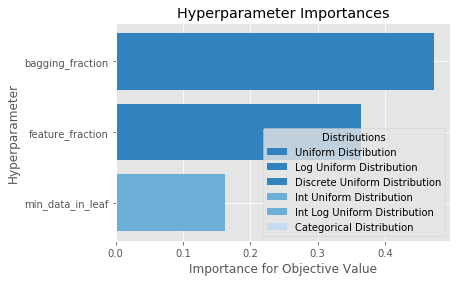

In [105]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

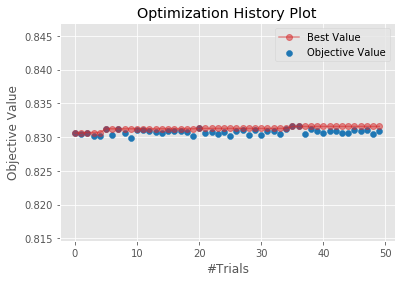

In [106]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

<Figure size 3600x3600 with 0 Axes>

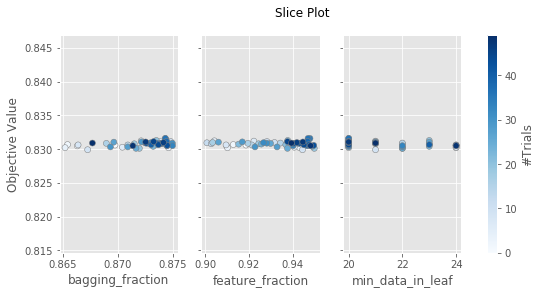

In [107]:
plt.figure(figsize=(50,50))
optuna.visualization.matplotlib.plot_slice(study)
plt.tight_layout
plt.show()

[W 2021-04-22 11:47:12,205] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


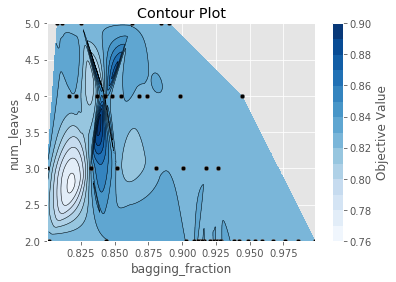

In [66]:
optuna.visualization.matplotlib.plot_contour(study, params=['bagging_fraction','num_leaves'])
plt.show()

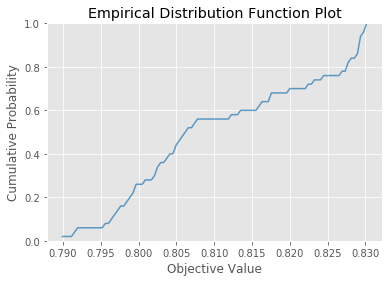

In [46]:
optuna.visualization.matplotlib.plot_edf(study)
plt.show()

In [108]:
#최종파라미터
lgb_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'num_leaves': 2,
        
        # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        'min_data_in_leaf': 20,
        # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'feature_fraction': 0.948,
        # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'bagging_fraction': 0.874,
        # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
        'bagging_freq': 3,
        'n_estimators': 10000, # 트리 개수
        'early_stopping_rounds': 100,
        'seed': SEED,
        'verbose': -1,
        'n_jobs': -1,    
    }

In [109]:
#out
train, test, y, features = feature_engineering2(data, '2011-12', months=14, badf=bad_features)
y_oof, test_preds, fi = make_lgb_oof_prediction(train, y, test, features, model_params=lgb_params)

categorical feature: ['year_month-mode']
x_tr.shape (5722, 378) , x_te.shape (5914, 378)
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.860992	valid_1's auc: 0.80278
Early stopping, best iteration is:
[163]	training's auc: 0.857376	valid_1's auc: 0.807907
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.857111	valid_1's auc: 0.826843
Early stopping, best iteration is:
[187]	training's auc: 0.856199	valid_1's auc: 0.82749
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.856699	valid_1's auc: 0.85051
Early stopping, best iteration is:
[159]	training's auc: 0.852016	valid_1's auc: 0.851816
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's auc: 0.843774	valid_1's auc: 0.817545
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.858782	valid_1's auc: 0.825273
Early stopping, best iter

### 제출파일 생성

In [110]:
output_dir = 'code/output'
os.makedirs(output_dir, exist_ok=True)
submission = pd.read_csv('boostcamp_source/input/sample_submission.csv')
submission['probability'] = test_preds
submission.to_csv(os.path.join(output_dir, 'output.csv'), index=False)